In [ ]:
# Run this if you can't import AlphaOpt
# Alternatively, use os.chdir('[AlphaOpt_directory]')
import os
#..\AlphaOpt\experiments\template
#..\AlphaOpt\experiments
%cd ".."
#..\AlphaOpt
%cd ".."

In [2]:
%pylab inline
import GPyOpt
import GPy

from AlphaOpt import components
from AlphaOpt.CustomCostModel import CustomCostModel as CostModel

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K
K.set_image_dim_ordering('th')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
# Get classes which have at least 70 examples
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [4]:
num_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
num_classes = lfw_people.target_names.shape[0]

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=4246)

In [5]:
def shapeData(data, h=h, w=w):
    return data.reshape(data.shape[0], 1, h, w).astype('float32')

def normalize(data):
    return data / 255

In [6]:
X_train = normalize(shapeData(X_train))
X_test = normalize(shapeData(X_test))
y_train = np_utils.to_categorical(y_train_raw)
y_test = np_utils.to_categorical(y_test_raw)

In [7]:
def baseline_model(dropout_rate=0.25, 
                   num_features=32, 
                   feature_size=5, 
                   pool_size=(2,2), 
                   fully_connected_size=256):
    """Baseline model with 1 convolution, 1 max pooling and 2 fully connected layers"""
    model = Sequential()
    model.add(Convolution2D(num_features, feature_size, feature_size, 
                            border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(fully_connected_size, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Manual Tuning

In [ ]:
manual_model = baseline_model()
manual_model.fit(X_train, y_train, 
              validation_data=(X_test, y_test), 
              nb_epoch=40, 
              batch_size=50,
              verbose=1)
manual_model.evaluate(X_test, y_test)[1] 

## Using GP for tuning

In [8]:
def cnn_accuracy(x):
    print(x)
    model = baseline_model(dropout_rate=x[0,0],
                           num_features=int(x[0,2]),
                           feature_size=int(x[0,3]),
                           pool_size=(int(x[0,4]),int(x[0,4])))
#                            fully_connected_size=x[0,4])
    model.fit(X_train, y_train, 
              validation_data=(X_test, y_test), 
              nb_epoch=int(x[0,1]), 
              batch_size=50,
              verbose=1)
    model.summary()
    return 1 / model.evaluate(X_test, y_test)[1]  # returns 1/accuracy
    
domain = [{'name': 'dropout_rate', 'type': 'continuous', 'domain': (0.01,0.99)},
          {'name': 'num_epoch', 'type': 'discrete', 'domain': range(10,41,10)},
          {'name': 'num_features', 'type': 'discrete', 'domain': range(10,101,10)},
          {'name': 'feature_size', 'type': 'discrete', 'domain': range(2,6)},
          {'name': 'pool_size', 'type': 'discrete', 'domain': range(1,6)}]
#           {'name': 'fully_connected_size', 'type': 'discrete', 'domain': range(num_classes,301,50)}]

In [9]:
objective = GPyOpt.core.task.SingleObjective(cnn_accuracy)
space = GPyOpt.Design_space(space=domain)
X_init = GPyOpt.util.stats.initial_design('random', space, 5)

In [10]:
# Bayesian Optimization Components
# GP models
model = GPyOpt.models.GPModel(kernel=GPy.kern.Matern52(input_dim=2, ARD=True),optimize_restarts=5,verbose=False)
cost = CostModel(GPy.kern.Matern52(input_dim=2, ARD=True), 'evaluation_time')

# Decision models
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
aquisition = GPyOpt.acquisitions.EI.AcquisitionEI(model, space, aquisition_optimizer)
evaluator = GPyOpt.core.evaluators.Sequential(aquisition)

In [11]:
# Combine everything
bo = GPyOpt.methods.ModularBayesianOptimization(model=model,
                                                space=space,
                                                objective=objective,
                                                acquisition=aquisition,
                                                evaluator=evaluator,
                                                X_init=X_init,
                                                cost=cost)

[[   0.13880445   30.          100.            2.            5.        ]]
Train on 901 samples, validate on 387 samples
Epoch 1/30
901/901 [==============================] - 14s - loss: 1.7212 - acc: 0.3907 - val_loss: 1.6582 - val_acc: 0.4238
Epoch 2/30
901/901 [==============================] - 19s - loss: 1.6937 - acc: 0.4062 - val_loss: 1.6423 - val_acc: 0.4238
Epoch 3/30
901/901 [==============================] - 30s - loss: 1.6257 - acc: 0.4062 - val_loss: 1.5890 - val_acc: 0.4264
Epoch 4/30
901/901 [==============================] - 28s - loss: 1.5732 - acc: 0.4229 - val_loss: 1.5181 - val_acc: 0.4341
Epoch 5/30
901/901 [==============================] - 28s - loss: 1.5336 - acc: 0.4661 - val_loss: 1.5091 - val_acc: 0.5478
Epoch 6/30
901/901 [==============================] - 28s - loss: 1.4646 - acc: 0.4850 - val_loss: 1.4224 - val_acc: 0.5478
Epoch 7/30
901/901 [==============================] - 28s - loss: 1.3880 - acc: 0.5150 - val_loss: 1.3641 - val_acc: 0.5349
Epoch 8/30
9

In [12]:
max_iter= 20
bo.run_optimization(max_iter=max_iter)

[[  0.51745466  40.          10.           2.           1.        ]]
Train on 901 samples, validate on 387 samples
Epoch 1/40
901/901 [==============================] - 3s - loss: 2.2474 - acc: 0.3452 - val_loss: 1.7814 - val_acc: 0.4238
Epoch 2/40
901/901 [==============================] - 3s - loss: 1.7163 - acc: 0.4062 - val_loss: 1.6352 - val_acc: 0.4238
Epoch 3/40
901/901 [==============================] - 3s - loss: 1.6359 - acc: 0.4073 - val_loss: 1.5715 - val_acc: 0.4264
Epoch 4/40
901/901 [==============================] - 3s - loss: 1.5727 - acc: 0.4395 - val_loss: 1.5120 - val_acc: 0.4419
Epoch 5/40
901/901 [==============================] - 3s - loss: 1.4831 - acc: 0.4673 - val_loss: 1.4437 - val_acc: 0.5323
Epoch 6/40
901/901 [==============================] - 4s - loss: 1.4285 - acc: 0.5205 - val_loss: 1.3730 - val_acc: 0.4599
Epoch 7/40
901/901 [==============================] - 4s - loss: 1.3164 - acc: 0.5327 - val_loss: 1.3328 - val_acc: 0.4599
Epoch 8/40
901/901 [====

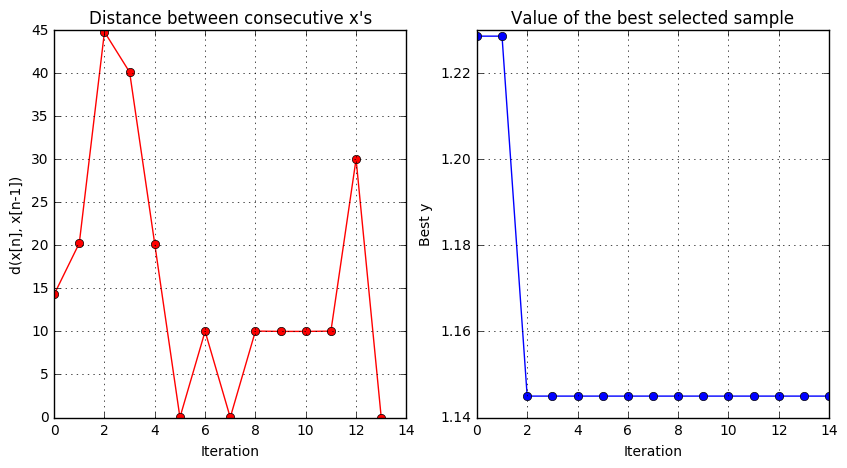

In [13]:
bo.plot_acquisition()
bo.plot_convergence() # Note: Value is 1/accuracy.

In [15]:
bo.X[np.argmin(bo.Y)]

array([  0.51712603,  40.        ,  90.        ,   3.        ,   2.        ])